<a href="https://colab.research.google.com/github/AndresLAraque/Sistemas-Recomendacion/blob/main/MINE_4201_Laboratorio_3_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# solo ejecutar si esta en colab y necesita instalar librerias
!pip install surprise
!pip install sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195831 sha256=d28304c8beee12dc7016ca5b9593d39c6024b72b4f00d9e656ead0bc60eee5cd
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2658 sha256=432964d94c0136aaf5cc454869b3cce29fccc45f75106d15801a45da7dee0802
  Stored in directory: /root/.cache/pip/wheels/ff/12/fa/4d724fdfed493cfe12b239ae9a0bc26b2fd85bb7dc9ecde7c3
Successfully built sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

from surprise.model_selection import cross_validate
from surprise import Dataset,SVD,NormalPredictor
import matplotlib.pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import SVD

%matplotlib inline

# MINE 4201- Laboratorio 3 - SR por factorización

En este laboratorio se ajustará un modelo de factorización utilizando el framework Surprise:
https://surprise.readthedocs.io/en/stable/index.html

Los datos fueron previamente separados en conjunto de entrenamiento, validación y test.

## 1. Exploración de los datasets de entrenamiento, validación y prueba

Ejecute las siguientes líneas y concluya sobre cómo están construidos estos datasets

In [4]:
pwd

'/content'

In [5]:
#Cambie el path de los datos dependiendo de donde estan (máquina local o google colab)

In [6]:
path='/content/drive/MyDrive/Laboratorio3/data/'

In [7]:
train_df = pd.read_csv( path+'train', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ], engine = 'python' )
validation_df = pd.read_csv( path+'validation', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp'], engine = 'python' )
test_df = pd.read_csv( path+'test', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ], engine = 'python' )
movies_df=pd.read_csv(path+'movies.csv')

In [8]:
type(train_df)

pandas.core.frame.DataFrame

In [9]:
train_df.head( 5 )

user_id  item_id  rating  timestamp
0      181      930       1  878963275
1       13       72       4  882141727
2       13      181       5  882140354
3      181      619       3  878963086
4      181      334       1  878961749

In [10]:
train_df.describe()

user_id       item_id        rating     timestamp
count  81140.000000  81140.000000  81140.000000  8.114000e+04
mean     460.273047    430.530749      3.516207  8.834829e+08
std      265.245484    335.509074      1.126096  5.340285e+06
min        1.000000      1.000000      1.000000  8.747247e+08
25%      259.750000    173.000000      3.000000  8.794481e+08
50%      437.000000    328.000000      4.000000  8.826785e+08
75%      671.000000    642.000000      4.000000  8.881927e+08
max      943.000000   1682.000000      5.000000  8.932866e+08

405    717
655    665
13     616
450    520
276    498
      ... 
302      1
78       1
231      1
341      1
818      1
Name: user_id, Length: 911, dtype: int64


405    717
Name: user_id, dtype: int64

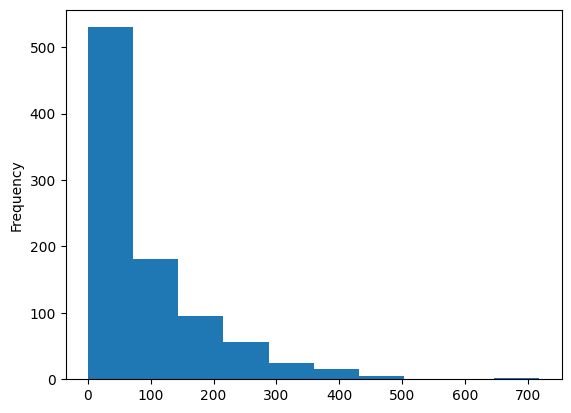

In [11]:
train_df['user_id'].value_counts().plot.hist()
print(train_df['user_id'].value_counts())
train_df['user_id'].loc[train_df['user_id'] == 405].value_counts()

El siguiente histrograma representa la cantidad de veces que un usuario interactua en la aplicaciòn, alli se puede observar que presenta un sesgo a hacia la derecha indicando que los primeros 100 usuarios son los que mas actividad presentan, por otra parte los usuarios con id superior a 600 presentan una menor interacciòn.

# La siguiente grafica representa 

<Axes: ylabel='Frequency'>

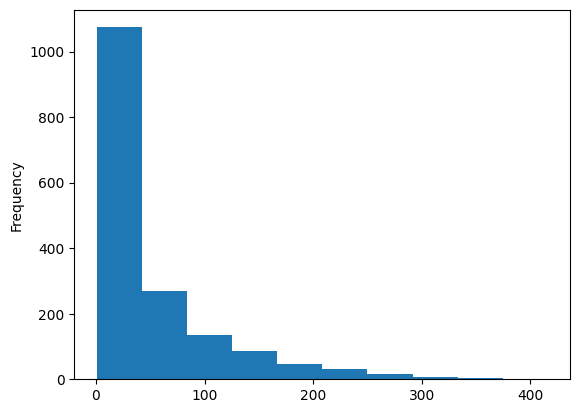

In [12]:
train_df['item_id'].value_counts().plot.hist()
#print(train_df.describe().value_counts())
#train_df['item_id'].loc[train_df['item_id'] == 80].value_counts()

En la siguiente figura se puede observar los primeros items entrenados presentan una mayor relevancias y son los que se repriten con mayor frecuencia, especificamente los menores a 50, de ahí en adelante presenta un comportamiento exponencial descendente, y por otra parte los items menores a 400 tiene frecuencias bajas o casi nulas 

In [13]:
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [14]:
conteo_peliculas=train_df['item_id'].value_counts().to_frame()

In [15]:
conteo_peliculas.columns=['conteo']

In [16]:
conteo_peliculas=conteo_peliculas.merge(movies_df, how='left', right_on='movieId', left_index=True)

In [17]:
conteo_peliculas.head(20)

conteo  movieId                                              title  \
49.0      416       50                         Usual Suspects, The (1995)   
179.0     386      181     Mighty Morphin Power Rangers: The Movie (1995)   
98.0      372      100                                   City Hall (1996)   
0.0       345        1                                   Toy Story (1995)   
172.0     343      174                                   Jury Duty (1995)   
119.0     336      121                    Boys of St. Vincent, The (1992)   
96.0      315       98                                    Shopping (1994)   
290.0     315      294                           Perez Family, The (1995)   
55.0      312       56                     Kids of the Round Table (1995)   
125.0     312      127  Silences of the Palace, The (Saimt el Qusur) (...   
255.0     312      258               Kid in King Arthur's Court, A (1995)   
283.0     301      286                           Nemesis 2: Nebula (1995)   
6.0       293        7                                     Sabrina (1995)   
170.0     291      172                             Johnny Mnemonic (1995)   
285.0     289      288                        Natural Born Killers (1994)   
78.0      286       79                                  Juror, The (1996)   
234.0     285      237                                Forget Paris (1995)   
202.0     283      204               Under Siege 2: Dark Territory (1995)   
115.0     282      117              Young Poisoner's Handbook, The (1995)   
166.0     278      168                                First Knight (1995)   

                                            genres  
49.0                        Crime|Mystery|Thriller  
179.0                              Action|Children  
98.0                                Drama|Thriller  
0.0    Adventure|Animation|Children|Comedy|Fantasy  
172.0                                       Comedy  
119.0                                        Drama  
96.0                               Action|Thriller  
290.0                               Comedy|Romance  
55.0             Adventure|Children|Comedy|Fantasy  
125.0                                        Drama  
255.0    Adventure|Children|Comedy|Fantasy|Romance  
283.0                       Action|Sci-Fi|Thriller  
6.0                                 Comedy|Romance  
170.0                       Action|Sci-Fi|Thriller  
285.0                        Action|Crime|Thriller  
78.0                                Drama|Thriller  
234.0                               Comedy|Romance  
202.0                                       Action  
115.0                                  Crime|Drama  
166.0                         Action|Drama|Romance

La pelicula mas calificada es 416

In [18]:
validation_df.head( 5 )

user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

In [19]:
test_df.head( 5 )

user_id  item_id  rating  timestamp
0       13      498       4  882139901
1       13      892       3  882774224
2       13      229       4  882397650
3      181      741       1  878962918
4      181     1015       1  878963121

In [20]:
train_df[['rating','timestamp']].describe()

rating     timestamp
count  81140.000000  8.114000e+04
mean       3.516207  8.834829e+08
std        1.126096  5.340285e+06
min        1.000000  8.747247e+08
25%        3.000000  8.794481e+08
50%        4.000000  8.826785e+08
75%        4.000000  8.881927e+08
max        5.000000  8.932866e+08

user_id  item_id  rating  timestamp
1        1        5       874965758    1
595      222      3       886921274    1
         268      4       886920576    1
         258      4       886920602    1
         255      3       886921392    1
                                      ..
311      495      4       884366066    1
         494      4       884364593    1
         493      4       884364465    1
         491      4       884365168    1
943      1330     3       888692465    1
Length: 81140, dtype: int64

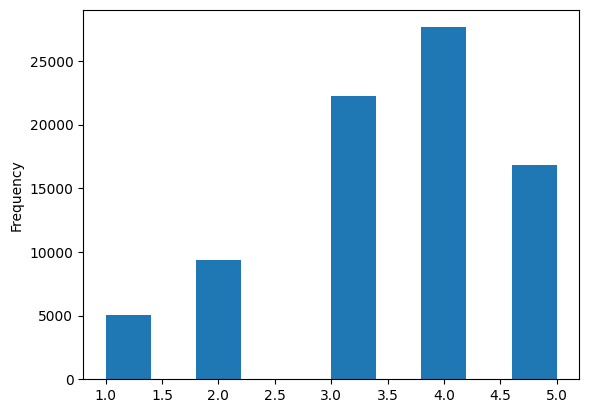

In [21]:
train_df.rating.plot.hist()
train_df.value_counts()

El siguiente histograma permite visualizar la cantidad de veces que se realiza una calificación, donde se puede observar es menos frecuente una baja calificación y la mejor valoraciòn es 4

In [22]:
validation_df[['rating','timestamp']].describe()

rating     timestamp
count  9430.000000  9.430000e+03
mean      3.587805  8.837354e+08
std       1.120240  5.360562e+06
min       1.000000  8.747247e+08
25%       3.000000  8.794515e+08
50%       4.000000  8.833904e+08
75%       4.000000  8.886378e+08
max       5.000000  8.932866e+08

user_id  item_id  rating  timestamp
1        20       4       887431883    1
630      1040     4       885667660    1
629      187      5       880117031    1
         204      5       880117285    1
         269      3       880115840    1
                                      ..
315      98       4       879821193    1
         185      4       879821267    1
         273      3       879821349    1
         305      5       881017419    1
943      1067     2       875501756    1
Length: 9430, dtype: int64

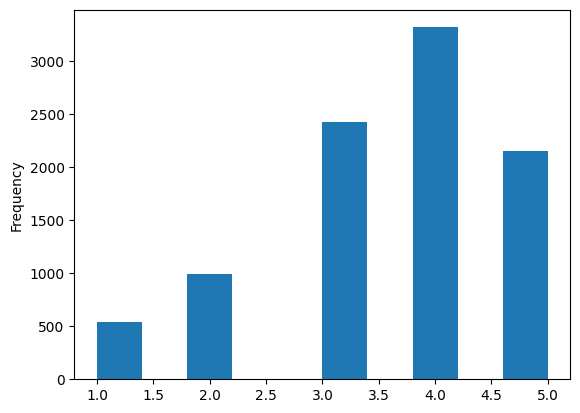

In [23]:
validation_df.rating.plot.hist()
validation_df.value_counts()

En este historgrama se mantiene la proporcianlidad del set de entrenamiento, unicamente varia la escala del dataset de validación

In [24]:
test_df[['rating','timestamp']].describe()

rating     timestamp
count  9430.000000  9.430000e+03
mean      3.589396  8.837179e+08
std       1.123800  5.349370e+06
min       1.000000  8.747249e+08
25%       3.000000  8.794518e+08
50%       4.000000  8.833653e+08
75%       4.000000  8.886326e+08
max       5.000000  8.932866e+08

<Axes: ylabel='Frequency'>

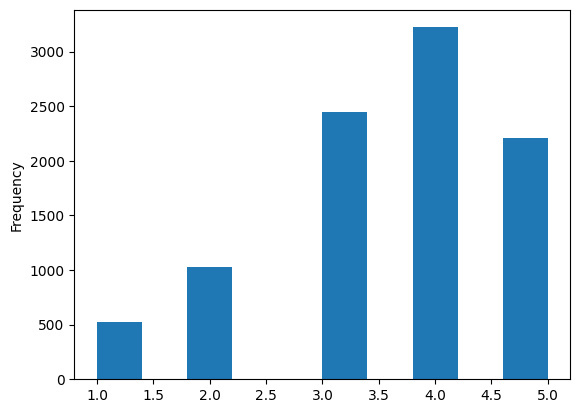

In [25]:
test_df.rating.plot.hist()

In [26]:
print( 'Train size: ' + str( train_df.shape ) )
print('Validation size: ' + str( validation_df.shape ) )
print( 'Test size: ' + str( test_df.shape ) )

Train size: (81140, 4)
Validation size: (9430, 4)
Test size: (9430, 4)


La distribución de datos de habilitaciones es equivalente en el dataframe de tren, validación y prueba. Significa que los conjuntos de datos para entrenar y probar nuestro modelo de recomendación son similares para ser coherentes

In [27]:
# En movies queda la información sobre las películas y su id
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

## 2. Transformación de los dataset al formato de Surprise

El framework lee los dataframes de pandas y los transforma a un formato que es aceptado por él

In [28]:
# Se establece el rango en el cual se aceptaran los ratings
reader = Reader( rating_scale = ( 1, 5 ) )

In [29]:
# Transformación de los datasets, puede leer los datasets directamente desde el disco sin necesidad de pasar por pandas
train_data = Dataset.load_from_df( train_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )
validation_data = Dataset.load_from_df( validation_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )
test_data = Dataset.load_from_df( test_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )

In [30]:
# Surprise requiere que explicitamente los datasets sean transformados a datasets de entrenamiento y prueba en cada caso 
# Si bien no se entrenará sobre los datasets de validación y prueba, surprise requiere que sean tranformados a entrenamiento para posteriormente ser transformados a prueba
train_data = train_data.build_full_trainset()
validation_data = validation_data.build_full_trainset()
test_data = test_data.build_full_trainset()

In [31]:
# Finalmente, se convierten los 3 datasets a prueba ya que se medirá el error obtenido en los 3
train_data_2 = train_data.build_testset()
validation_data = validation_data.build_testset()
test_data = test_data.build_testset()

In [32]:
type(train_data)

surprise.trainset.Trainset

Cada película queda representada en el conjunto train con un id interno para los modelos de factorización, revise la documentación sobre ids internos y externos [aqui](https://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note)

In [33]:
movies_df.loc[movies_df.movieId==1]

movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy

In [34]:
#Revisar el id interno de la película con id 1 en el dataset
train_data.to_inner_iid(1)

16

## 3. Entrenamiento de un modelo SVD con bias

El modelo toma como base el promedio global. En este caso es de 3.5162

In [35]:
mean = train_data.global_mean
print( mean )

3.516206556568893


La clase SVD recibe los siguientes parámetros:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
* n_factors: Número k de factores para realizar la recomendación
* n_epochs: Número de iteraciones a realizar sobre los datos
* biased: Si el modelo contempla los bias o solo la factorización
* lr_all: Tasa de aprendizaje del método
* reg_all: Parámetro de regularización
* init_mean y init_std_dev son los parámetros de la distribución usada para inicializar aleatoriamente los factores

Se prueba un modelo con bias sin regularización para k=5




In [36]:
algo = SVD( n_factors = 5, n_epochs = 200, biased = True, lr_all = 0.001, reg_all = 0, init_mean = 0, init_std_dev = 0.01, verbose = True )

In [37]:
# Se realiza el entrenamiento a partir del dataset debido
algo.fit( train_data )

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

Al finalizar el entrenamiento, se visualiza cómo quedo la matriz que representa a los usuarios ($p_u$) y la matriz que representa a los items ($q_i$)

In [38]:
pu = algo.pu

In [39]:
pu.shape

(911, 5)

<Axes: >

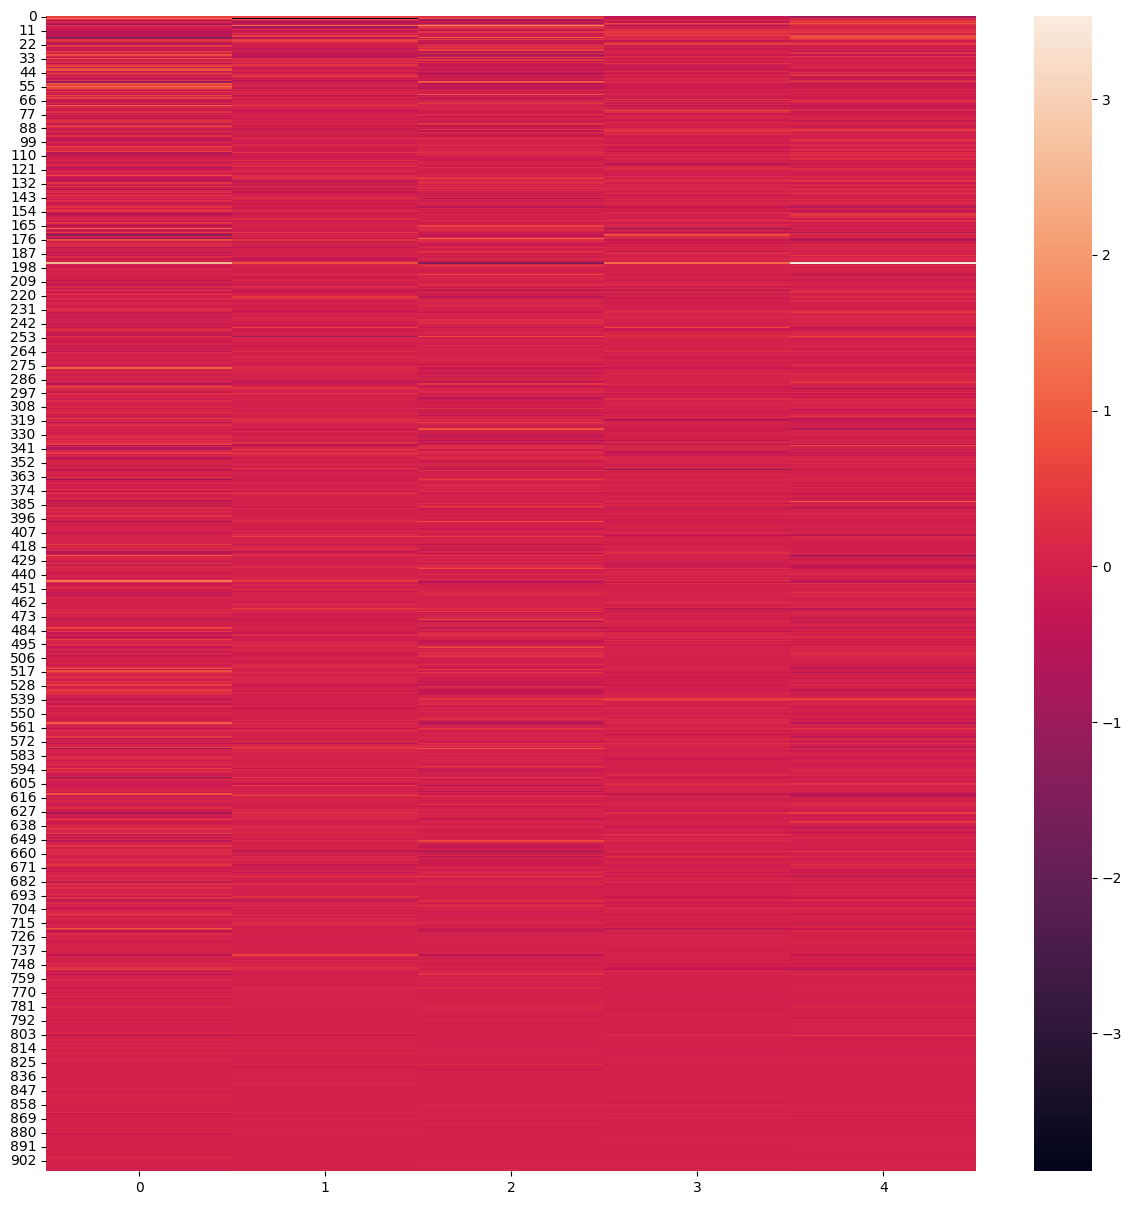

In [40]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( pu, ax = ax )

In [41]:
qi = algo.qi

<Axes: >

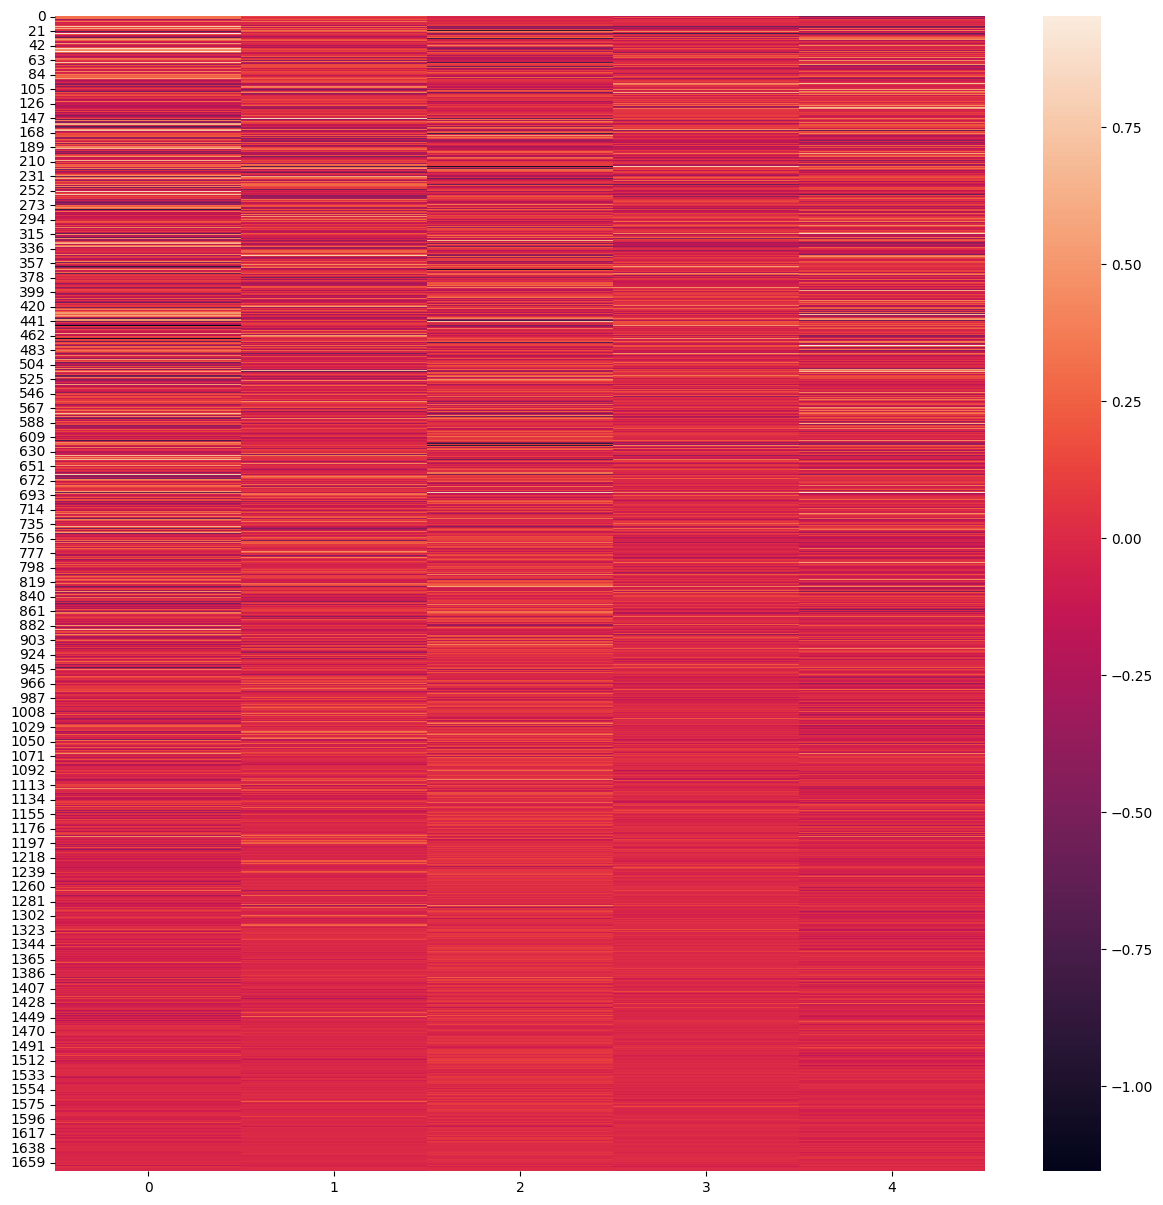

In [42]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( qi , ax = ax)

También se pueden visualizar los bias de usuarios e items $b_u$ y $b_i$

In [43]:
bi = algo.bi.reshape( algo.bi.shape[ 0 ], 1 )
bu = algo.bu.reshape( algo.bu.shape[ 0 ], 1 )

<Axes: >

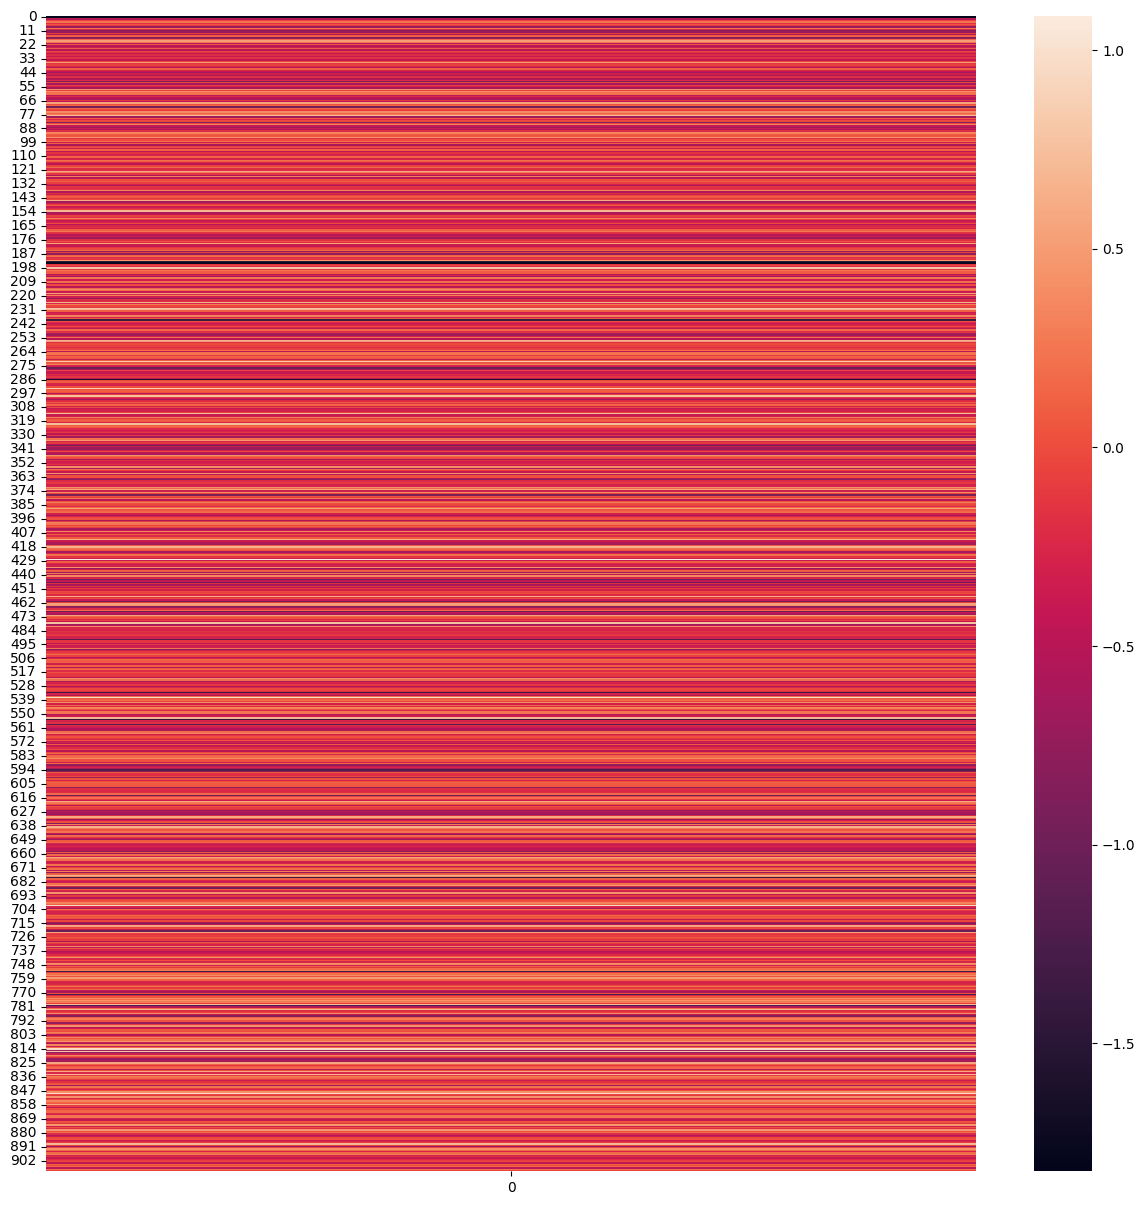

In [44]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( bu ,ax = ax)

<Axes: >

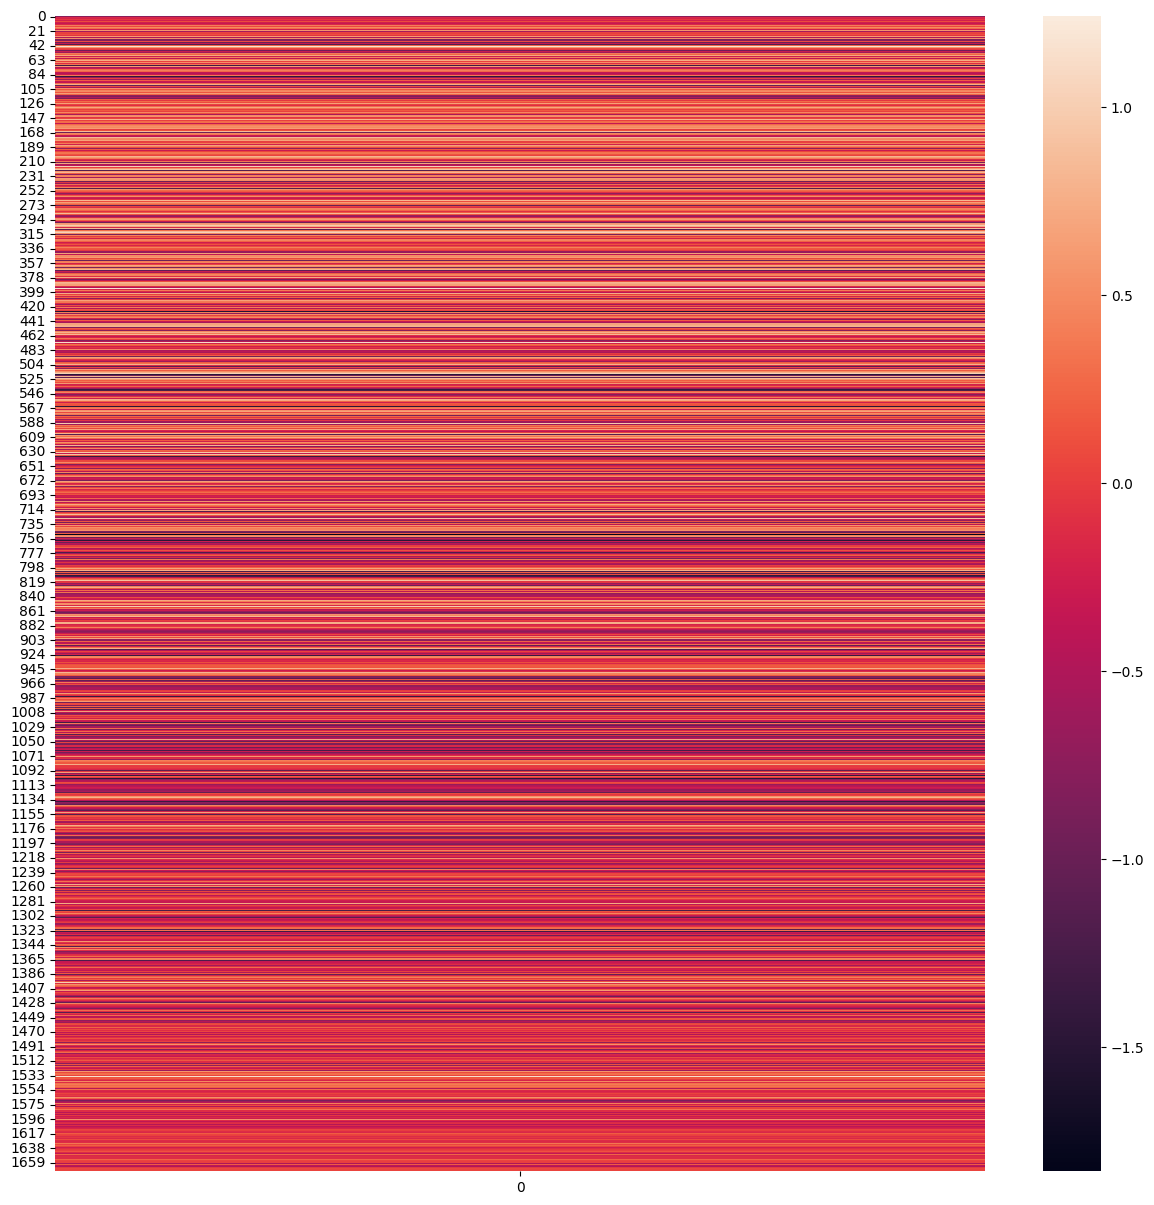

In [45]:
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( bi, ax = ax )

In [46]:
bi.shape

(1672, 1)

In [47]:
# Ejemplo bias de película con id 1
bi[train_data.to_inner_iid(1)]

array([0.49379425])

In [48]:
#Película con el máximo bias

In [49]:
np.amax(bi)

1.2406604210613004

In [50]:
np.where(bi==np.amax(bi))

(array([591]), array([0]))

In [51]:
bi[1534]

array([1.1480472])

In [52]:
train_data.to_raw_iid(1534)

1449

In [53]:
conteo_peliculas[conteo_peliculas.movieId==train_data.to_raw_iid(1534)]

conteo  movieId                       title  genres
1409.0       7     1449  Waiting for Guffman (1996)  Comedy

In [54]:
train_df[train_df.item_id==train_data.to_raw_iid(1534)]

user_id  item_id  rating  timestamp
32518      561     1449       5  885808620
33292      409     1449       5  881107817
39592      585     1449       5  891283338
50049      385     1449       4  881047049
56498      934     1449       5  891191976
63269      234     1449       4  892333573
75662      932     1449       5  891248937

### Reconstrucción de la matriz original

Una vez se realiza la factorización, se puede reconstruir la predicción para cada una de las coordenadas de la matriz original

$\hat{r}_{ui}= \mu + b_{i} + b_{u} + p_{u}\dot q_{i}^{T} $

In [55]:
reconstruct = ( pu ).dot( ( qi ).T ) + bu + bi.T + mean

<Axes: >

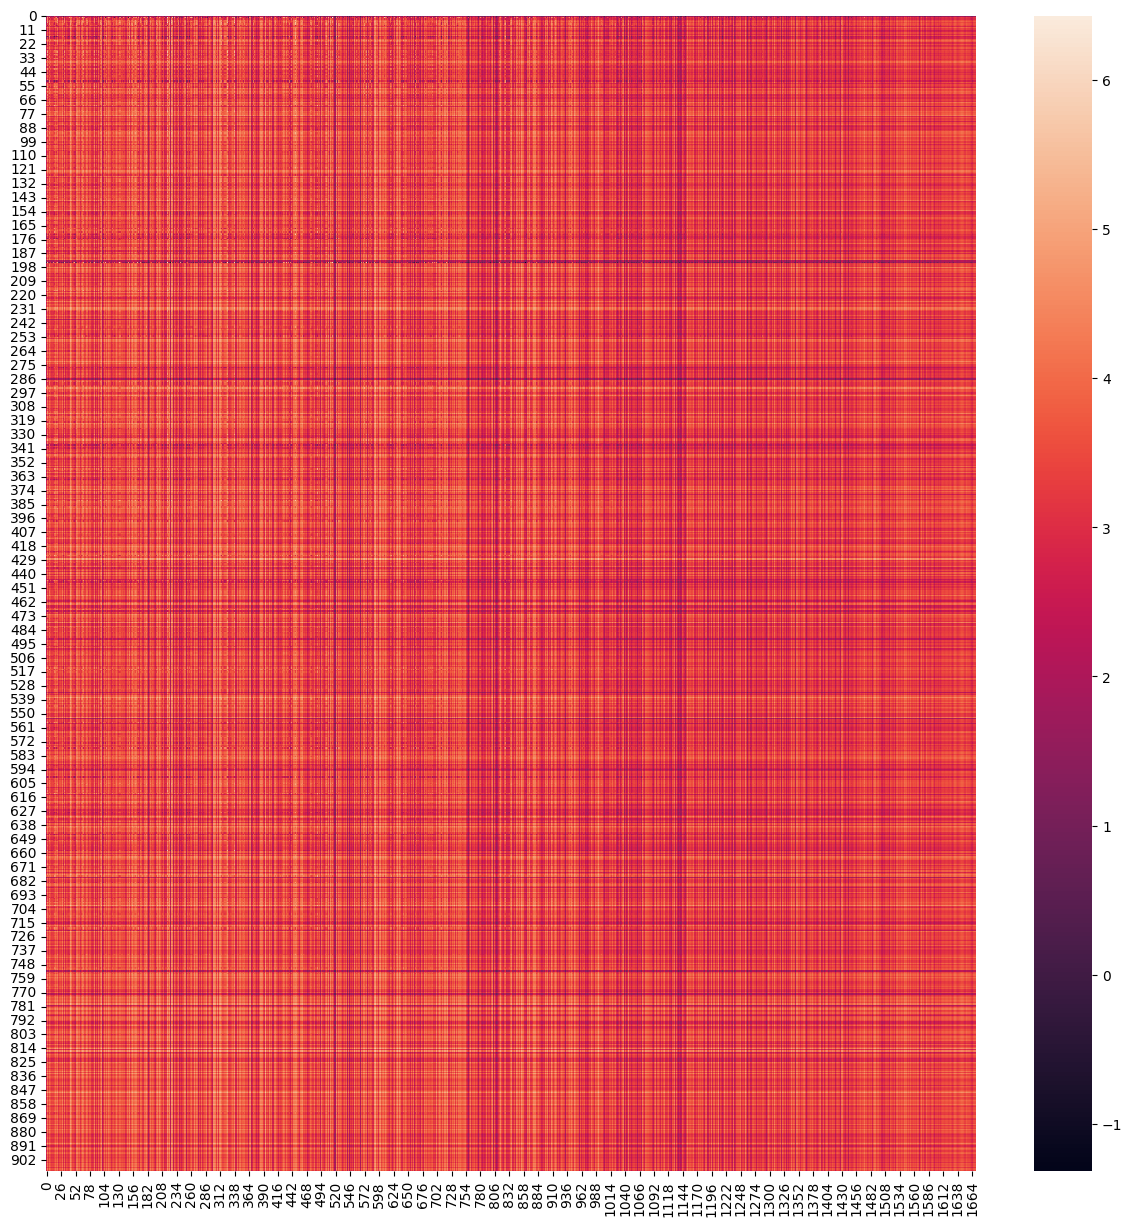

In [56]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( reconstruct, ax = ax )

<Axes: >

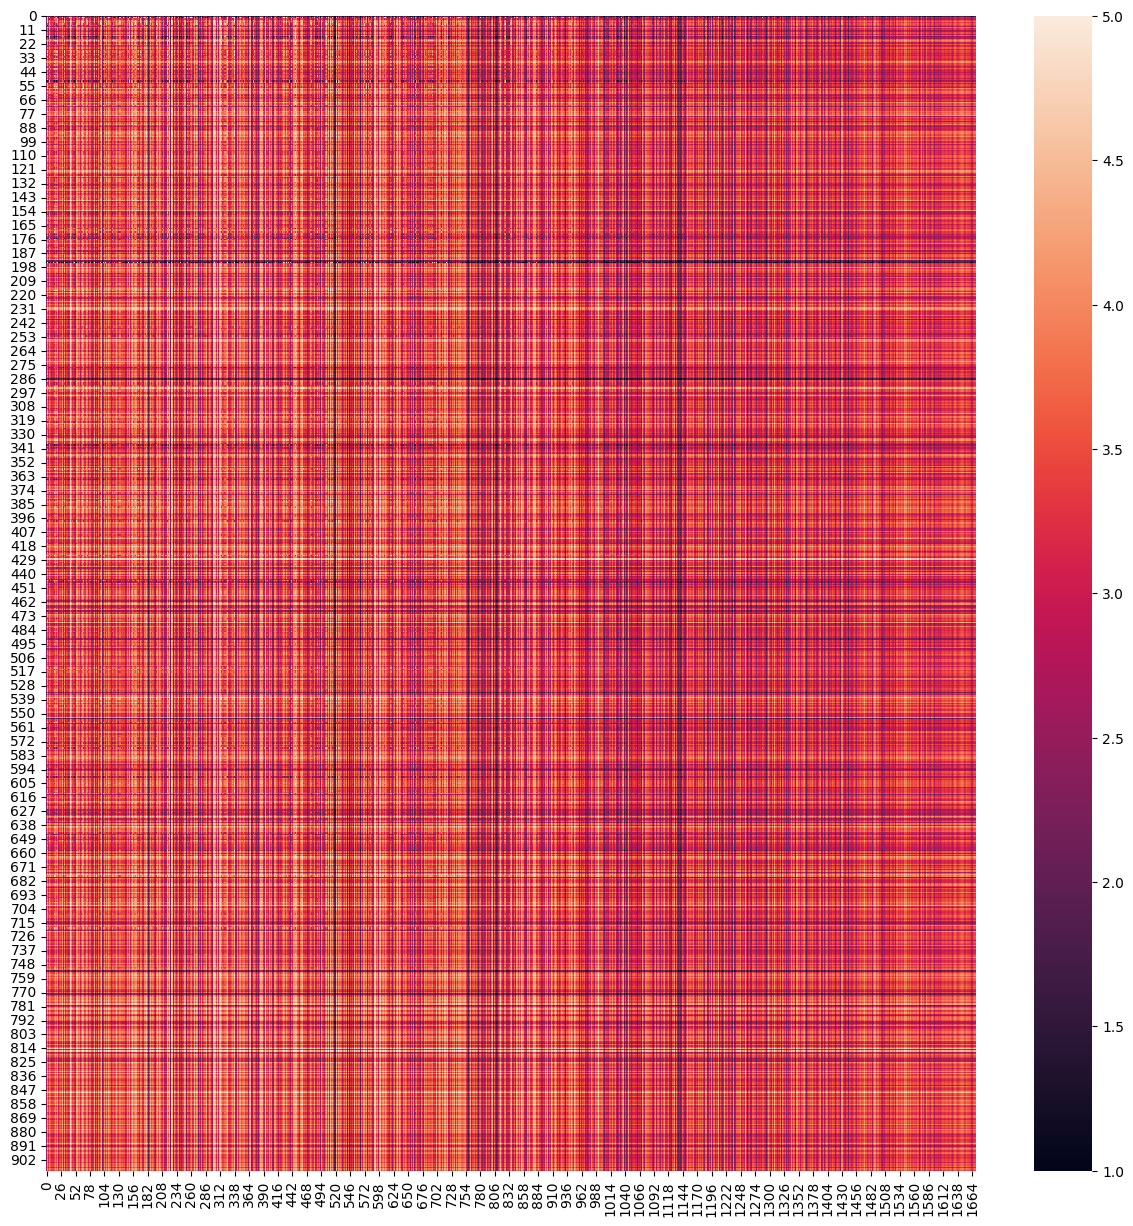

In [57]:
# Ya que algunos ratings reconstruidos están fuera del rango aceptado, se realiza un ajuste entre 1 y 5
reconstruct = np.clip( reconstruct, 1, 5 )
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( reconstruct , ax = ax)

Compare los resultados con la matriz original:

In [58]:
original = np.zeros( ( train_data.n_users , train_data.n_items ) )
for ( u, i, r ) in train_data.all_ratings():
    original[ u ][ i ] = r

<Axes: >

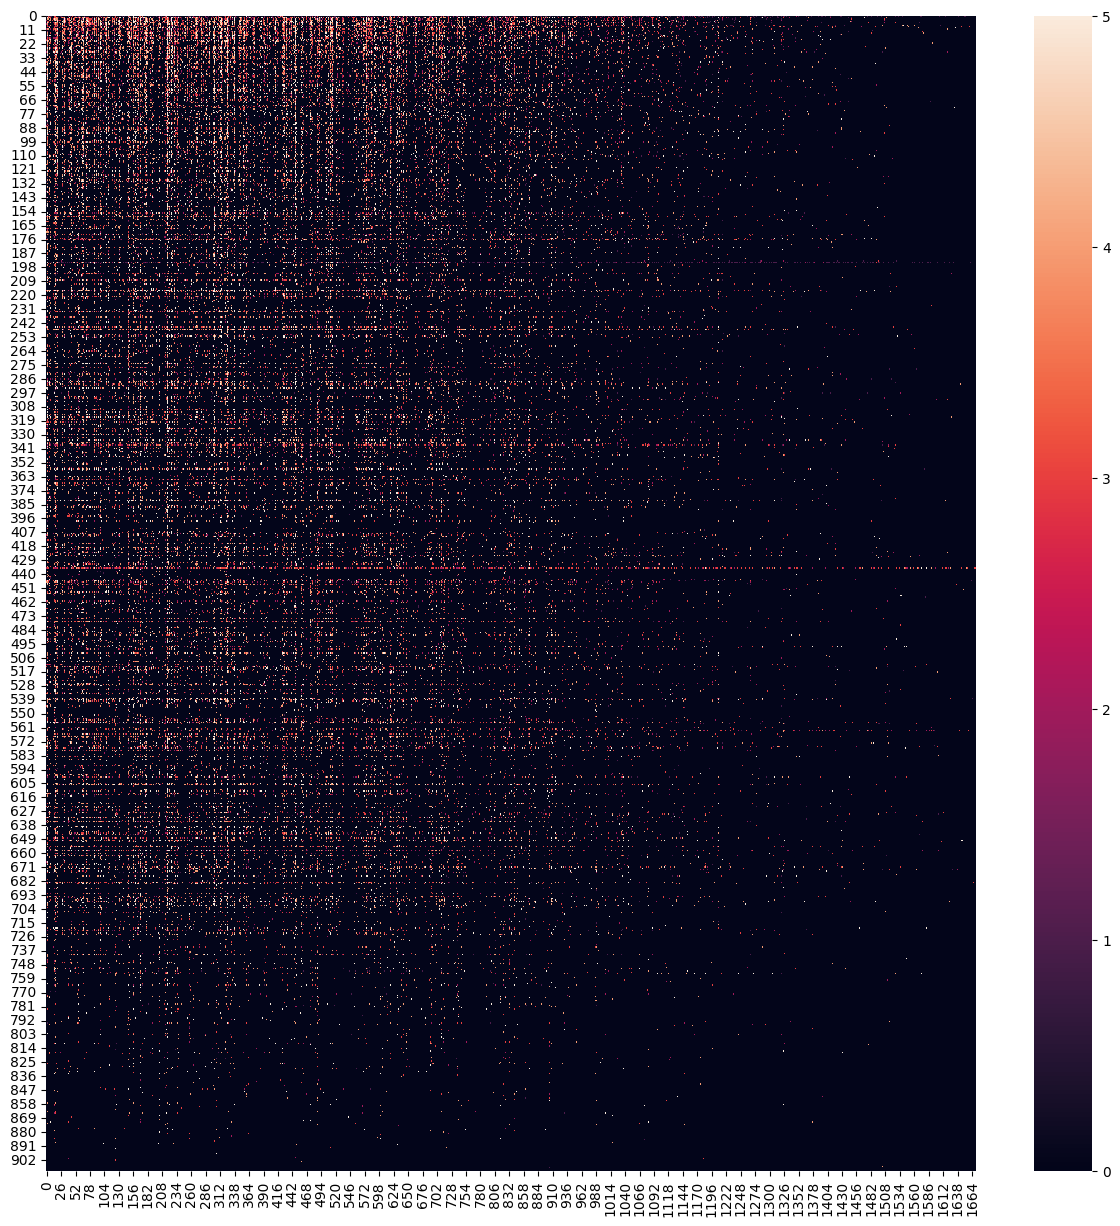

In [59]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( original, ax = ax )

### Se compara visualmente el error en las entradas conocidas de la matriz ( error en conjunto de entrenamiento )

In [60]:
known_entries = original == 0

In [61]:
reconstruct[ known_entries ] = 0

<Axes: >

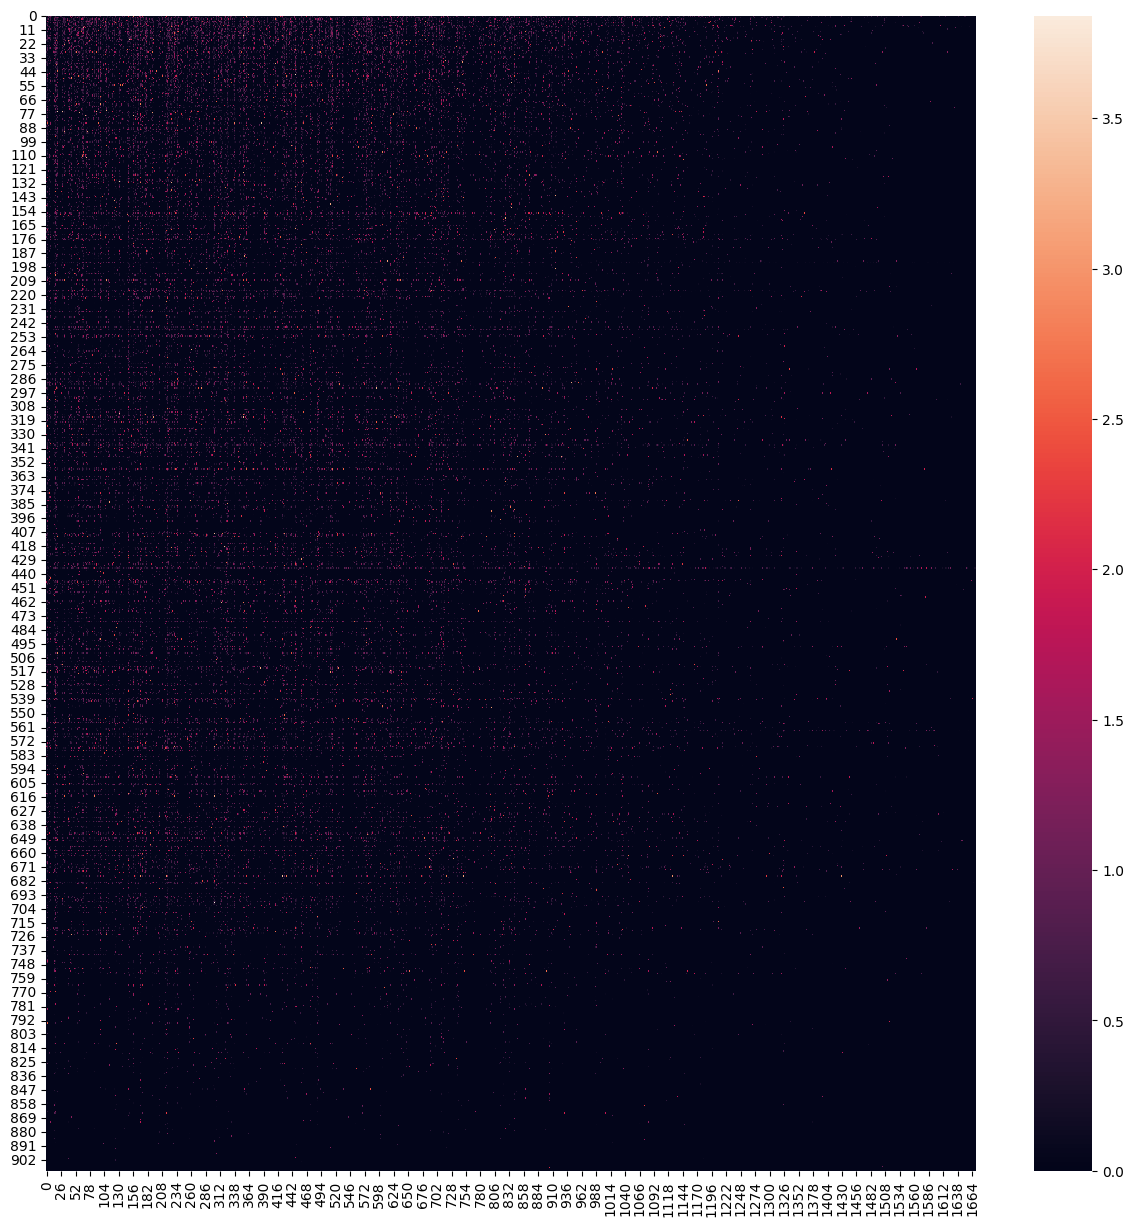

In [62]:
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( np.abs( original - reconstruct ) , ax = ax)

## 3. Evaluación de predicciones

A partir del modelo entrenado, se mide el error del modelo en el conjunto de entrenamiento, validación y prueba

In [63]:
predictions_train = algo.test( train_data_2 )

In [64]:
predictions_validation = algo.test( validation_data )
predictions_test = algo.test( test_data )

In [65]:
accuracy.rmse( predictions_train, verbose = True )

RMSE: 0.8362


0.8362384822091885

In [66]:
accuracy.rmse( predictions_validation, verbose = True )

RMSE: 0.9595


0.9594706470138682

In [67]:
accuracy.rmse( predictions_test, verbose = True )

RMSE: 0.9741


0.9740815172878737

## 4. Selección de hiper-parámetros

Utilice este notebook para realizar los siguientes ajustes:

4.1 Aumente el número k de dimensiones del vector y documente los resultados. Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores (cree una gráfica donde muestre el efecto que tiene k sobre los errores)

4.2 Para un k fijo, aumente la regularización para diferentes valores [0.001,0.01,0.1,1,10].  Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores, por ejemplo, comparando los tamaños de los parámetros.

4.3 ¿Según los resultados obtenidos, qué otros hiperparámetros cambiaría y en qué dirección para mejorar el performance del modelo?

In [68]:
data = train_data
type(data)

surprise.trainset.Trainset

{'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
RMSE: 0.8446
RMSE: 0.8226
RMSE: 0.8052
RMSE: 0.7884
RMSE: 0.7786
RMSE: 0.7684
RMSE: 0.7627
RMSE: 0.7536
RMSE: 0.7490
RMSE: 0.7435


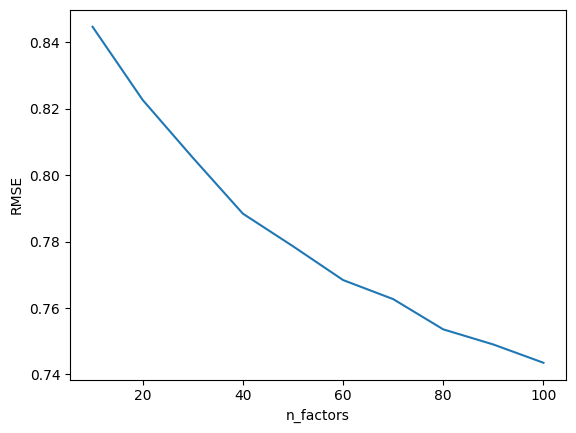

In [69]:
# Cargar los datos
reader = Reader()
train_data = Dataset.load_from_df( train_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )
trainset = train_data.build_full_trainset()

# Definir la cuadrícula de parámetros
param_grid = {'n_factors': [20], 'n_epochs': [20, 30], 'lr_all': [0.005, 0.01], 'reg_all': [0.02,0.1]}

# Realizar la búsqueda de cuadrícula
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(train_data)

# Mostrar los mejores parámetros
print(gs.best_params['rmse'])

# Ajustar el modelo con diferentes valores de n_factors y guardar los errores
n_factors_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
error_list = []
for n_factors in n_factors_list:
    model = SVD(n_factors=n_factors, n_epochs=gs.best_params['rmse']['n_epochs'], lr_all=gs.best_params['rmse']['lr_all'], reg_all=gs.best_params['rmse']['reg_all'])
    model.fit(trainset)
    predictions = model.test(trainset.build_testset())
    error = accuracy.rmse(predictions)
    error_list.append(error)

# Graficar los errores en función de n_factors
plt.plot(n_factors_list, error_list)
plt.xlabel('n_factors')
plt.ylabel('RMSE')
plt.show()

{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}
RMSE: 0.4896
RMSE: 0.5189
RMSE: 0.8291
RMSE: 0.9670
RMSE: 1.0892


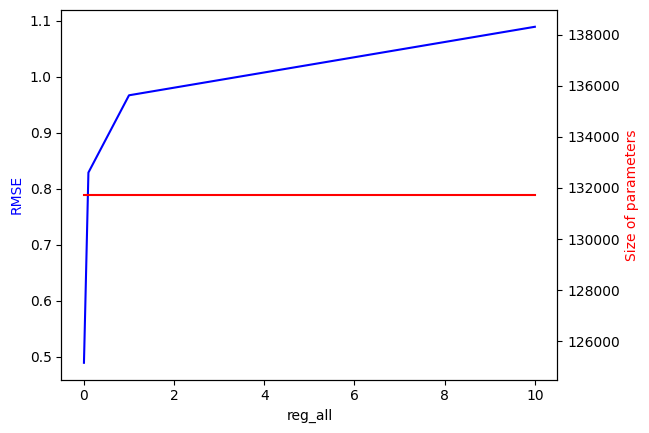

In [70]:
# Cargar los datos
#reader = Reader()
#train_data = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
#trainset = train_data.build_full_trainset()

# Definir la cuadrícula de parámetros
param_grid = {'n_factors': [50], 'n_epochs': [20], 'lr_all': [0.01], 'reg_all': [0.001, 0.01, 0.1, 1, 10]}

# Realizar la búsqueda de cuadrícula
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(train_data)

# Mostrar los mejores parámetros
print(gs.best_params['rmse'])

# Ajustar el modelo con diferentes valores de reg_all y guardar los errores y tamaños de parámetros
reg_all_list = [0.001, 0.01, 0.1, 1, 10]
error_list = []
param_size_list = []
for reg_all in reg_all_list:
    model = SVD(n_factors=gs.best_params['rmse']['n_factors'], n_epochs=gs.best_params['rmse']['n_epochs'], lr_all=gs.best_params['rmse']['lr_all'], reg_all=reg_all)
    model.fit(trainset)
    predictions = model.test(trainset.build_testset())
    error = accuracy.rmse(predictions)
    error_list.append(error)
    param_size = model.bu.shape[0] + model.bi.shape[0] + (model.qi.shape[0] + model.pu.shape[0]) * model.qi.shape[1]
    param_size_list.append(param_size)

# Graficar los errores y tamaños de parámetros en función de reg_all
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(reg_all_list, error_list, 'b-')
ax2.plot(reg_all_list, param_size_list, 'r-')
ax1.set_xlabel('reg_all')
ax1.set_ylabel('RMSE', color='b')
ax2.set_ylabel('Size of parameters', color='r')
plt.show()